In [ ]:
# checking the current working directory and configuring project root
import os
import sys
# setting the project root as one level above the notebooks folder
PROJECT_ROOT = os.path.abspath("..")
print("PROJECT_ROOT:", PROJECT_ROOT)
# adding the project root to the system path for module imports
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

PROJECT_ROOT: c:\Users\salma\OneDrive\Desktop\SpTp_Final_Project\illumination_invariant_superpixels


In [ ]:
# importing plotting and numerical libraries
import matplotlib.pyplot as plt
import numpy as np
# importing project configuration and preprocessing utilities
from src import config
from src.preprocessing import load_image
# importing raw and color-constancy pipelines
from src.pipelines import run_raw_pipeline, run_cc_pipeline
# importing superpixel visualization helper
from src.superpixels import overlay_superpixels
# importing stability metric for comparison across lighting conditions
from src.metrics import compute_stability, boundary_iou, variation_of_information
import pandas as pd


=== Processing object: apple ===
Images: ['apple_01.png', 'apple_02.png', 'apple_03.png', 'apple_04.png', 'apple_05.png', 'apple_06.png', 'apple_07.png', 'apple_08.png', 'apple_09.png', 'apple_10.png', 'apple_original.png']
Reference image: apple_01.png
  running pipelines on: apple_01.png
  running pipelines on: apple_02.png
  running pipelines on: apple_03.png
  running pipelines on: apple_04.png
  running pipelines on: apple_05.png
  running pipelines on: apple_06.png
  running pipelines on: apple_07.png
  running pipelines on: apple_08.png
  running pipelines on: apple_09.png
  running pipelines on: apple_10.png
  running pipelines on: apple_original.png

=== Processing object: deer ===
Images: ['deer_01.png', 'deer_02.png', 'deer_03.png', 'deer_04.png', 'deer_05.png', 'deer_06.png', 'deer_07.png', 'deer_08.png', 'deer_09.png', 'deer_10.png', 'deer_original.png']
Reference image: deer_01.png
  running pipelines on: deer_01.png
  running pipelines on: deer_02.png
  running pipeline

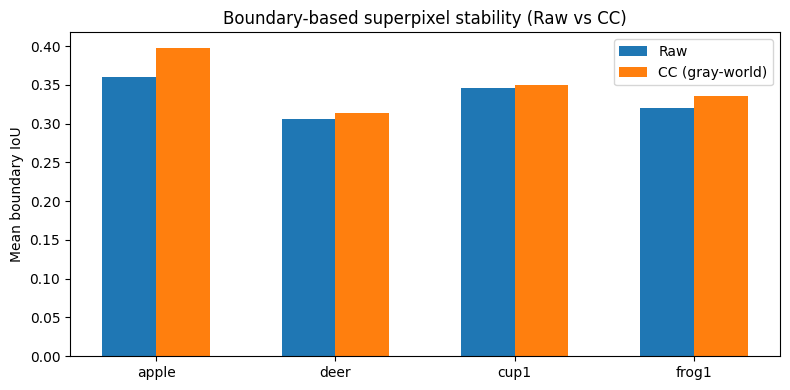

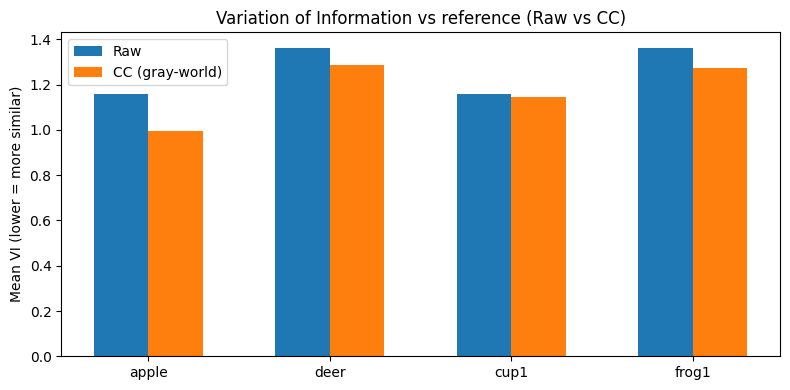

In [14]:
# setting the list of object names to evaluate
object_names = ["apple", "deer", "cup1", "frog1"]
# creating a list to store all summary rows
rows = []
# running stability analysis for each object
for object_name in object_names:
    # listing all images for this object under varying illumination
    all_files = sorted(
        f for f in os.listdir(config.RAW_DIR)
        if f.startswith(object_name + "_") and f.endswith(".png"))
    # checking if images exist
    if len(all_files) == 0:
        print(f"[WARNING] no images for '{object_name}'")
        continue
    print(f"\n=== Processing object: {object_name} ===")
    print("Images:", all_files)
    # selecting the first image as the reference
    ref_name = all_files[0]
    print("Reference image:", ref_name)
    # creating dictionaries to store superpixel labels
    labels_raw_dict = {}
    labels_cc_dict = {}
    # running raw and color constancy pipelines on all images
    for fname in all_files:
        print("  running pipelines on:", fname)
        # loading the image
        img = load_image(fname)
        # running raw SLIC pipeline
        labels_raw = run_raw_pipeline(img)
        # running color constancy SLIC pipeline
        img_cc, labels_cc = run_cc_pipeline(img, cc_method="gray_world")
        # storing computed labels
        labels_raw_dict[fname] = labels_raw
        labels_cc_dict[fname] = labels_cc
    # getting reference segmentations
    ref_raw = labels_raw_dict[ref_name]
    ref_cc = labels_cc_dict[ref_name]
    # creating lists for metrics across all lighting conditions
    stab_raw = []
    stab_cc = []
    b_iou_raw = []
    b_iou_cc = []
    vi_raw = []
    vi_cc = []
    # computing metrics for each illumination condition
    for fname in all_files:
        lr = labels_raw_dict[fname]
        lc = labels_cc_dict[fname]
        # computing neighbor-based stability
        stab_raw.append(compute_stability(ref_raw, lr))
        stab_cc.append(compute_stability(ref_cc, lc))
        # computing boundary IoU
        b_iou_raw.append(boundary_iou(ref_raw, lr))
        b_iou_cc.append(boundary_iou(ref_cc, lc))
        # computing variation of information
        vi_raw.append(variation_of_information(ref_raw, lr))
        vi_cc.append(variation_of_information(ref_cc, lc))
    # converting lists to numpy arrays
    stab_raw = np.array(stab_raw)
    stab_cc = np.array(stab_cc)
    b_iou_raw = np.array(b_iou_raw)
    b_iou_cc = np.array(b_iou_cc)
    vi_raw = np.array(vi_raw)
    vi_cc = np.array(vi_cc)
    # storing summary metrics for this object
    rows.append({
        "object": object_name,
        "num_images": len(all_files),
        "mean_neighbor_stab_raw": float(stab_raw.mean()),
        "mean_neighbor_stab_cc": float(stab_cc.mean()),
        "mean_boundary_iou_raw": float(b_iou_raw.mean()),
        "mean_boundary_iou_cc": float(b_iou_cc.mean()),
        "mean_vi_raw": float(vi_raw.mean()),
        "mean_vi_cc": float(vi_cc.mean()),})
# creating a dataframe with all object summaries
df = pd.DataFrame(rows)
print("\nStability summary (neighbor + boundary IoU + VI)")
print(df)
# saving the summary to CSV
os.makedirs(config.METRICS_DIR, exist_ok=True)
out_csv = os.path.join(config.METRICS_DIR, "stability_summary_all_metrics.csv")
df.to_csv(out_csv, index=False)
print("\nSaved to:", out_csv)
# plotting boundary IoU comparison between pipelines
if len(df) > 0:
    x = np.arange(len(df))
    plt.figure(figsize=(8, 4))
    plt.bar(x - 0.15, df["mean_boundary_iou_raw"], width=0.3, label="Raw")
    plt.bar(x + 0.15, df["mean_boundary_iou_cc"], width=0.3, label="CC (gray-world)")
    plt.xticks(x, df["object"])
    plt.ylabel("Mean boundary IoU")
    plt.title("Boundary-based superpixel stability (Raw vs CC)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    # plotting variation of information comparison between pipelines
    plt.figure(figsize=(8, 4))
    plt.bar(x - 0.15, df["mean_vi_raw"], width=0.3, label="Raw")
    plt.bar(x + 0.15, df["mean_vi_cc"], width=0.3, label="CC (gray-world)")
    plt.xticks(x, df["object"])
    plt.ylabel("Mean VI (lower = more similar)")
    plt.title("Variation of Information vs reference (Raw vs CC)")
    plt.legend()
    plt.tight_layout()
    plt.show()


Creating grid for apple: ['apple_01.png', 'apple_05.png', 'apple_10.png']


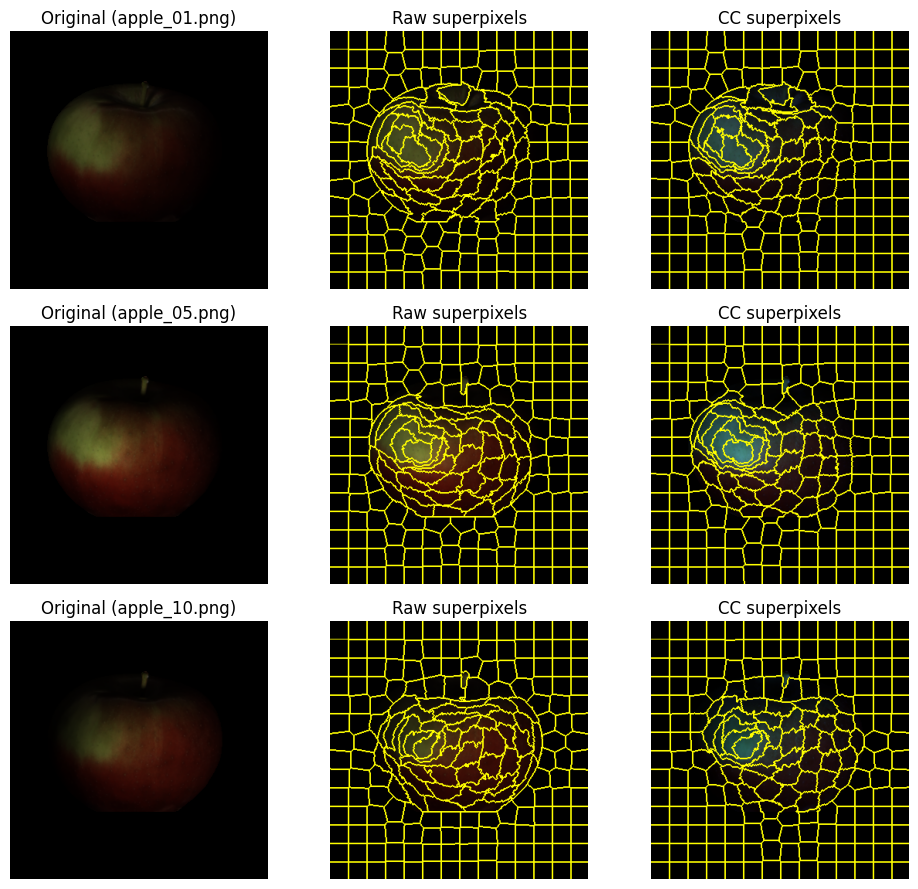

Saved grid to: c:\Users\salma\OneDrive\Desktop\SpTp_Final_Project\illumination_invariant_superpixels\results\figures\apple_illumination_grid.png

Creating grid for deer: ['deer_01.png', 'deer_05.png', 'deer_10.png']


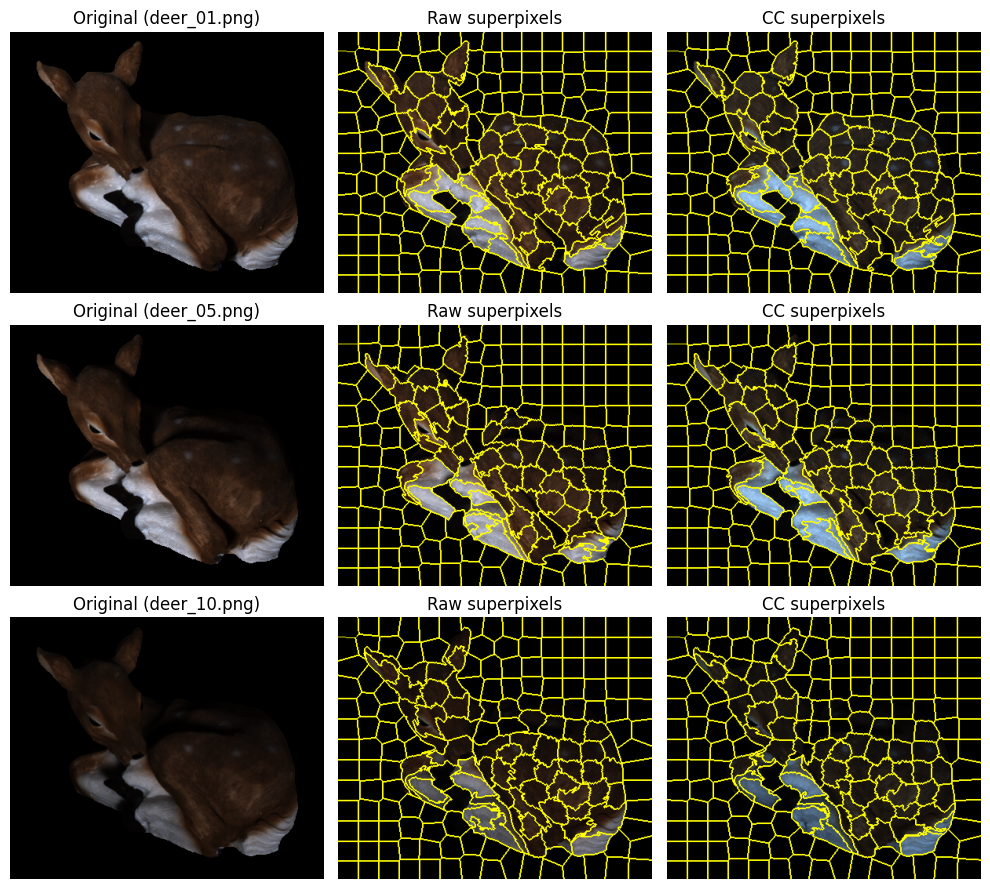

Saved grid to: c:\Users\salma\OneDrive\Desktop\SpTp_Final_Project\illumination_invariant_superpixels\results\figures\deer_illumination_grid.png

Creating grid for cup1: ['cup1_01.png', 'cup1_05.png', 'cup1_10.png']


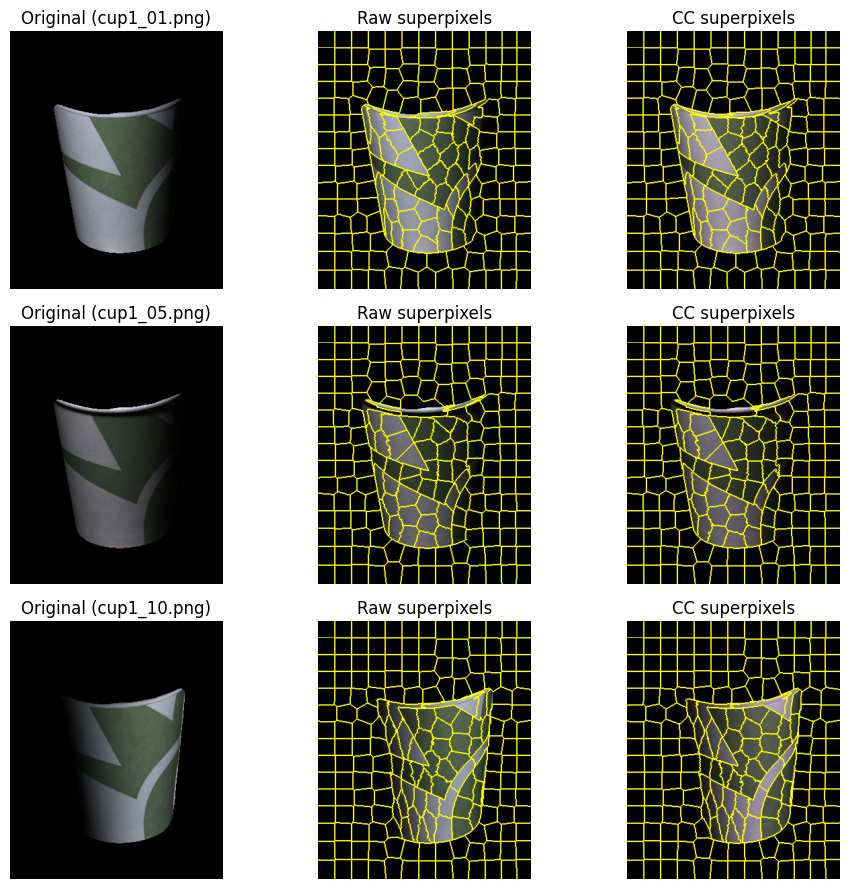

Saved grid to: c:\Users\salma\OneDrive\Desktop\SpTp_Final_Project\illumination_invariant_superpixels\results\figures\cup1_illumination_grid.png

Creating grid for frog1: ['frog1_01.png', 'frog1_05.png', 'frog1_10.png']


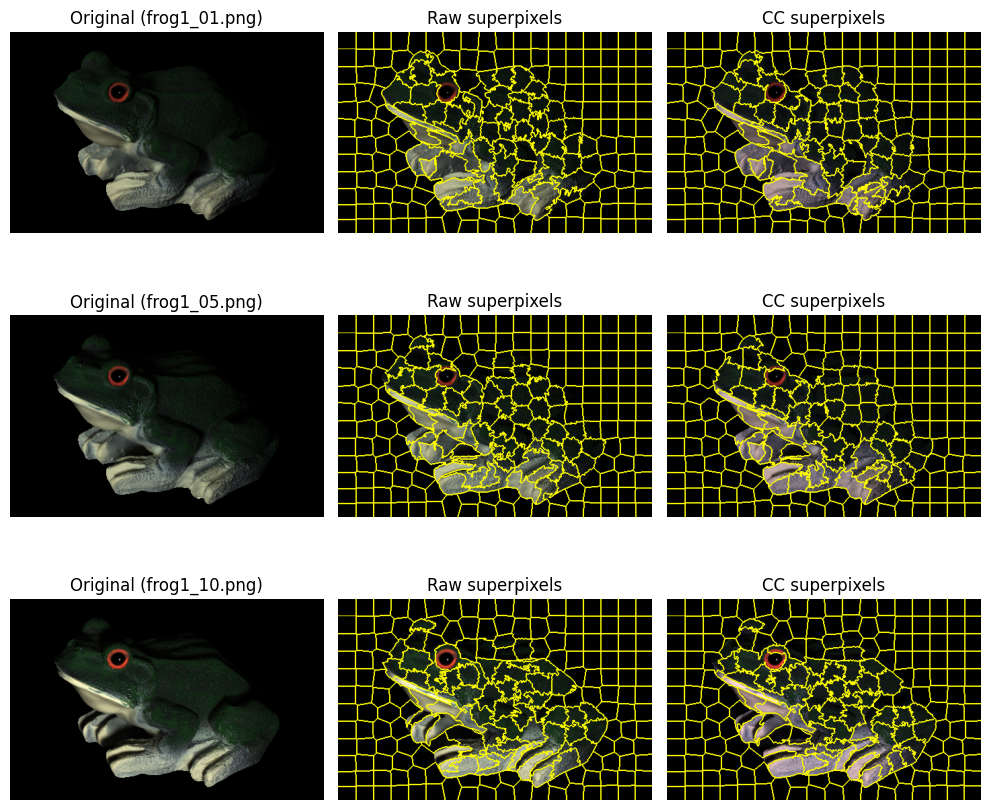

Saved grid to: c:\Users\salma\OneDrive\Desktop\SpTp_Final_Project\illumination_invariant_superpixels\results\figures\frog1_illumination_grid.png


In [ ]:
# creating the figures directory if missing
os.makedirs(config.FIGURES_DIR, exist_ok=True)
# setting the object names to visualize
object_names = ["apple", "deer", "cup1", "frog1"]
# selecting which lighting conditions to display
indices_to_show = [0, 4, 9]# showing first, middle and last lighting variations
# creating an illumination grid for each object
for object_name in object_names:
    # collecting all available images for this object
    all_files = sorted(
        f for f in os.listdir(config.RAW_DIR)
        if f.startswith(object_name + "_") and f.endswith(".png"))
    # checking for missing images
    if len(all_files) == 0:
        print(f"no images for '{object_name}'")
        continue
    # selecting valid indices based on available images
    idxs = [i for i in indices_to_show if i < len(all_files)]
    chosen_files = [all_files[i] for i in idxs]
    print(f"\nCreating grid for {object_name}: {chosen_files}")
    # creating a figure with one row per selected lighting condition
    n_rows = len(chosen_files)
    fig, axes = plt.subplots(n_rows, 3, figsize=(10, 3 * n_rows))
    # ensuring consistent 2D indexing even when only one row exists
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)  
    # generating visualizations for each chosen image
    for row, fname in enumerate(chosen_files):
        # loading the image
        img = load_image(fname)
        # running the raw pipeline
        labels_raw = run_raw_pipeline(img)
        # running the color-constancy pipeline
        img_cc, labels_cc = run_cc_pipeline(img, cc_method="gray_world")
        # creating overlay visualizations for superpixel boundaries
        overlay_raw = overlay_superpixels(img, labels_raw)
        overlay_cc = overlay_superpixels(img_cc, labels_cc)
        # displaying the original image
        axes[row, 0].imshow(img)
        axes[row, 0].set_title(f"Original ({fname})")
        axes[row, 0].axis("off")
        # displaying raw superpixels
        axes[row, 1].imshow(overlay_raw)
        axes[row, 1].set_title("Raw superpixels")
        axes[row, 1].axis("off")
        # displaying CC superpixels
        axes[row, 2].imshow(overlay_cc)
        axes[row, 2].set_title("CC superpixels")
        axes[row, 2].axis("off")
    plt.tight_layout()
    # saving the figure for this object
    out_path = os.path.join(
        config.FIGURES_DIR, f"{object_name}_illumination_grid.png")
    plt.savefig(out_path, dpi=200)
    plt.show()
    print("Saved grid to:", out_path)